In [1]:
#set random seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)


In [2]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight



In [3]:
kaggle_credentails = json.load(open("/content/kaggle.json"))

In [4]:

# setup Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [5]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.03G/2.04G [00:15<00:00, 247MB/s]
100% 2.04G/2.04G [00:15<00:00, 137MB/s]


In [6]:
!ls

kaggle.json  plantvillage-dataset.zip  sample_data


In [7]:
# Unzip the downloaded dataset
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [8]:
print(os.listdir("plantvillage dataset"))

print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['grayscale', 'color', 'segmented']
38
['Tomato___healthy', 'Strawberry___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Black_rot', 'Potato___healthy']
38
['Tomato___healthy', 'Strawberry___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Black_rot', 'Potato___healthy']
38
['Tomato___healthy', 'Strawberry___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Black_rot', 'Potato___healthy']


In [9]:
print(len(os.listdir("plantvillage dataset/color/Tomato___healthy")))
print(os.listdir("plantvillage dataset/color/Tomato___healthy")[:5])

1591
['c09f9b09-e43d-46bd-96d7-bb1162b4bb52___RS_HL 9644.JPG', '050e7bff-2f2d-4c92-9422-05ce93f1d5a9___RS_HL 0097.JPG', '3e03aa27-3c0c-447c-87da-c3375ef47ead___RS_HL 9899.JPG', '71867583-027b-4304-8854-7b88efaf280b___RS_HL 9920.JPG', '62fa284f-8fc8-46b7-a74d-71bada562464___RS_HL 0303.JPG']


In [10]:
print(os.listdir("plantvillage dataset/color/Tomato___Septoria_leaf_spot")[5])

96090c07-dbf5-46e4-94bf-bf0d06cdf907___Matt.S_CG 7796.JPG


In [11]:
#Dataset Path
base_dir="plantvillage dataset/color"

(256, 256, 3)


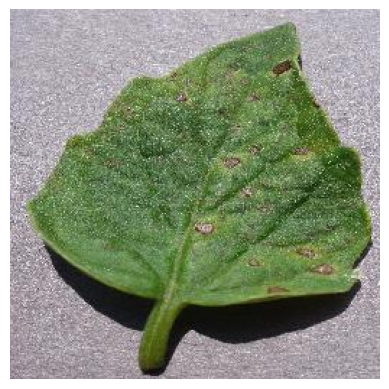

In [12]:
image_path='/content/plantvillage dataset/color/Tomato___Septoria_leaf_spot/96090c07-dbf5-46e4-94bf-bf0d06cdf907___Matt.S_CG 7796.JPG'
img = mpimg.imread(image_path)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
#Image parameter
img_size = 224
batch_size = 32

In [14]:
#image Data Generator with augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


#validation generator
val_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print("train image_shape:", train_generator.image_shape)

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
train image_shape: (224, 224, 3)


In [15]:
num_classes = train_generator.num_classes
print(train_generator.num_classes)

38


In [16]:
#Tranfer Learning Model
#Load EfficientNetB0
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size, img_size, 3)
)
base_model.trainable = False


#Adding Custom Layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

#Compile the Model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,098,249 (15.63 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [17]:
#Train (Stage 1 – Only Dense Layer)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 134s 78ms/step - accuracy: 0.0206 - loss: 3.6900 - val_accuracy: 0.0309 - val_loss: 3.6197 - learning_rate: 0.0010
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 85s 62ms/step - accuracy: 0.0166 - loss: 3.7231 - val_accuracy: 0.0238 - val_loss: 3.6019 - learning_rate: 0.0010
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.0182 - loss: 3.7241 - val_accuracy: 0.0073 - val_loss: 3.6790 - learning_rate: 0.0010
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 89s 66ms/step - accuracy: 0.0194 - loss: 3.6941 - val_accuracy: 0.0068 - val_loss: 3.7403 - learning_rate: 0.0010
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step - accuracy: 0.0180 - loss: 3.6827 - val_accuracy: 0.0175 - val_loss: 3.5888 - learning_rate: 3.0000e-04
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 80s 59ms/step - accuracy: 0.0211 - loss: 3.6718 - val_accuracy: 0.0423 - val_loss: 3.6088 - learning_rate: 3.0000e-04
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy

In [18]:
#Fine Tuning (Unfreeze EfficientNet)
base_model.trainable = True  # Unfreeze full model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:

#Train Again (Stage 2 – Fine-Tuning)
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=12,
    callbacks=callbacks
)

Epoch 1/12
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 271s 146ms/step - accuracy: 0.2808 - loss: 2.8939 - val_accuracy: 0.6994 - val_loss: 1.3174 - learning_rate: 1.0000e-05
Epoch 2/12
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 188s 138ms/step - accuracy: 0.7949 - loss: 0.8870 - val_accuracy: 0.9013 - val_loss: 0.4081 - learning_rate: 1.0000e-05
Epoch 3/12
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 188s 138ms/step - accuracy: 0.9057 - loss: 0.3811 - val_accuracy: 0.9619 - val_loss: 0.1506 - learning_rate: 1.0000e-05
Epoch 4/12
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 188s 138ms/step - accuracy: 0.9444 - loss: 0.2137 - val_accuracy: 0.9620 - val_loss: 0.1261 - learning_rate: 1.0000e-05
Epoch 5/12
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 189s 139ms/step - accuracy: 0.9603 - loss: 0.1470 - val_accuracy: 0.9748 - val_loss: 0.0844 - learning_rate: 1.0000e-05
Epoch 6/12
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 188s 138ms/step - accuracy: 0.9710 - loss: 0.1081 - val_accuracy: 0.9723 - val_loss: 0.0907 - learning_rate: 1.0000e-05
Epoch 7/12
1358/1358 ━━━━━━━

In [20]:
#Evaluate Model on Validation Set
print("Evaluating model...")
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Loss: {val_loss:.4f}")


Evaluating model...
339/339 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.9906 - loss: 0.0280
Validation Accuracy: 99.21%
Loss: 0.0257


In [21]:
#Combine Accuracy from Both Phases (history + history_fine)
full_train_acc = history.history['accuracy'] + history_fine.history['accuracy']
full_val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

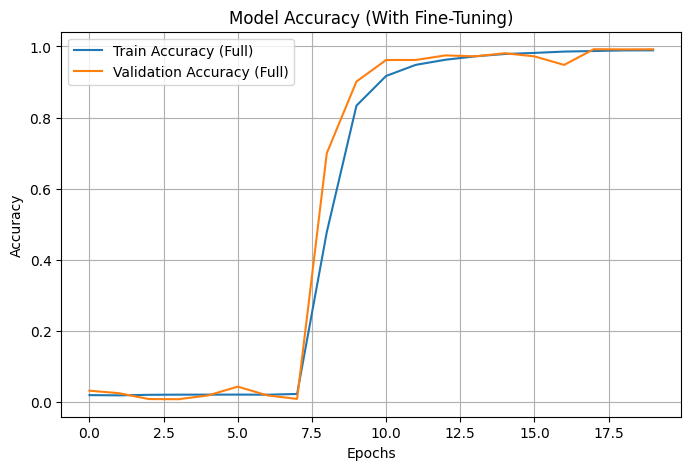

In [22]:
#Plot Accuracy Graph
plt.figure(figsize=(8, 5))
plt.plot(full_train_acc, label='Train Accuracy (Full)')
plt.plot(full_val_acc, label='Validation Accuracy (Full)')
plt.title('Model Accuracy (With Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
#Combine Loss from Both Phases
full_train_loss = history.history['loss'] + history_fine.history['loss']
full_val_loss = history.history['val_loss'] + history_fine.history['val_loss']


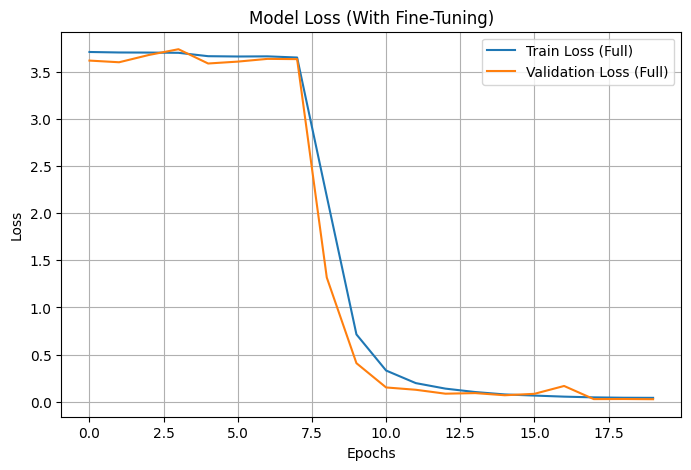

In [24]:

#Plot Loss Graph
plt.figure(figsize=(8, 5))
plt.plot(full_train_loss, label='Train Loss (Full)')
plt.plot(full_val_loss, label='Validation Loss (Full)')
plt.title('Model Loss (With Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Create a new validation generator with shuffle=False for correct evaluation
val_eval_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

val_eval_generator.reset()  # Just to be safe

# Get Class Names
class_names = list(val_eval_generator.class_indices.keys())

#Predictions
y_pred = model.predict(val_eval_generator)
predicted_labels = np.argmax(y_pred, axis=1)

# ✅ True labels in the same (non-shuffled) order
true_labels = val_eval_generator.classes

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=class_names))





Found 10849 images belonging to 38 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


340/340 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step
Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.99      1.00       126
                                 Apple___Black_rot       1.00      1.00      1.00       124
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                                   Apple___healthy       0.99      1.00      1.00       329
                               Blueberry___healthy       1.00      1.00      1.00       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.89      0.90       102
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       238
            

In [39]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)



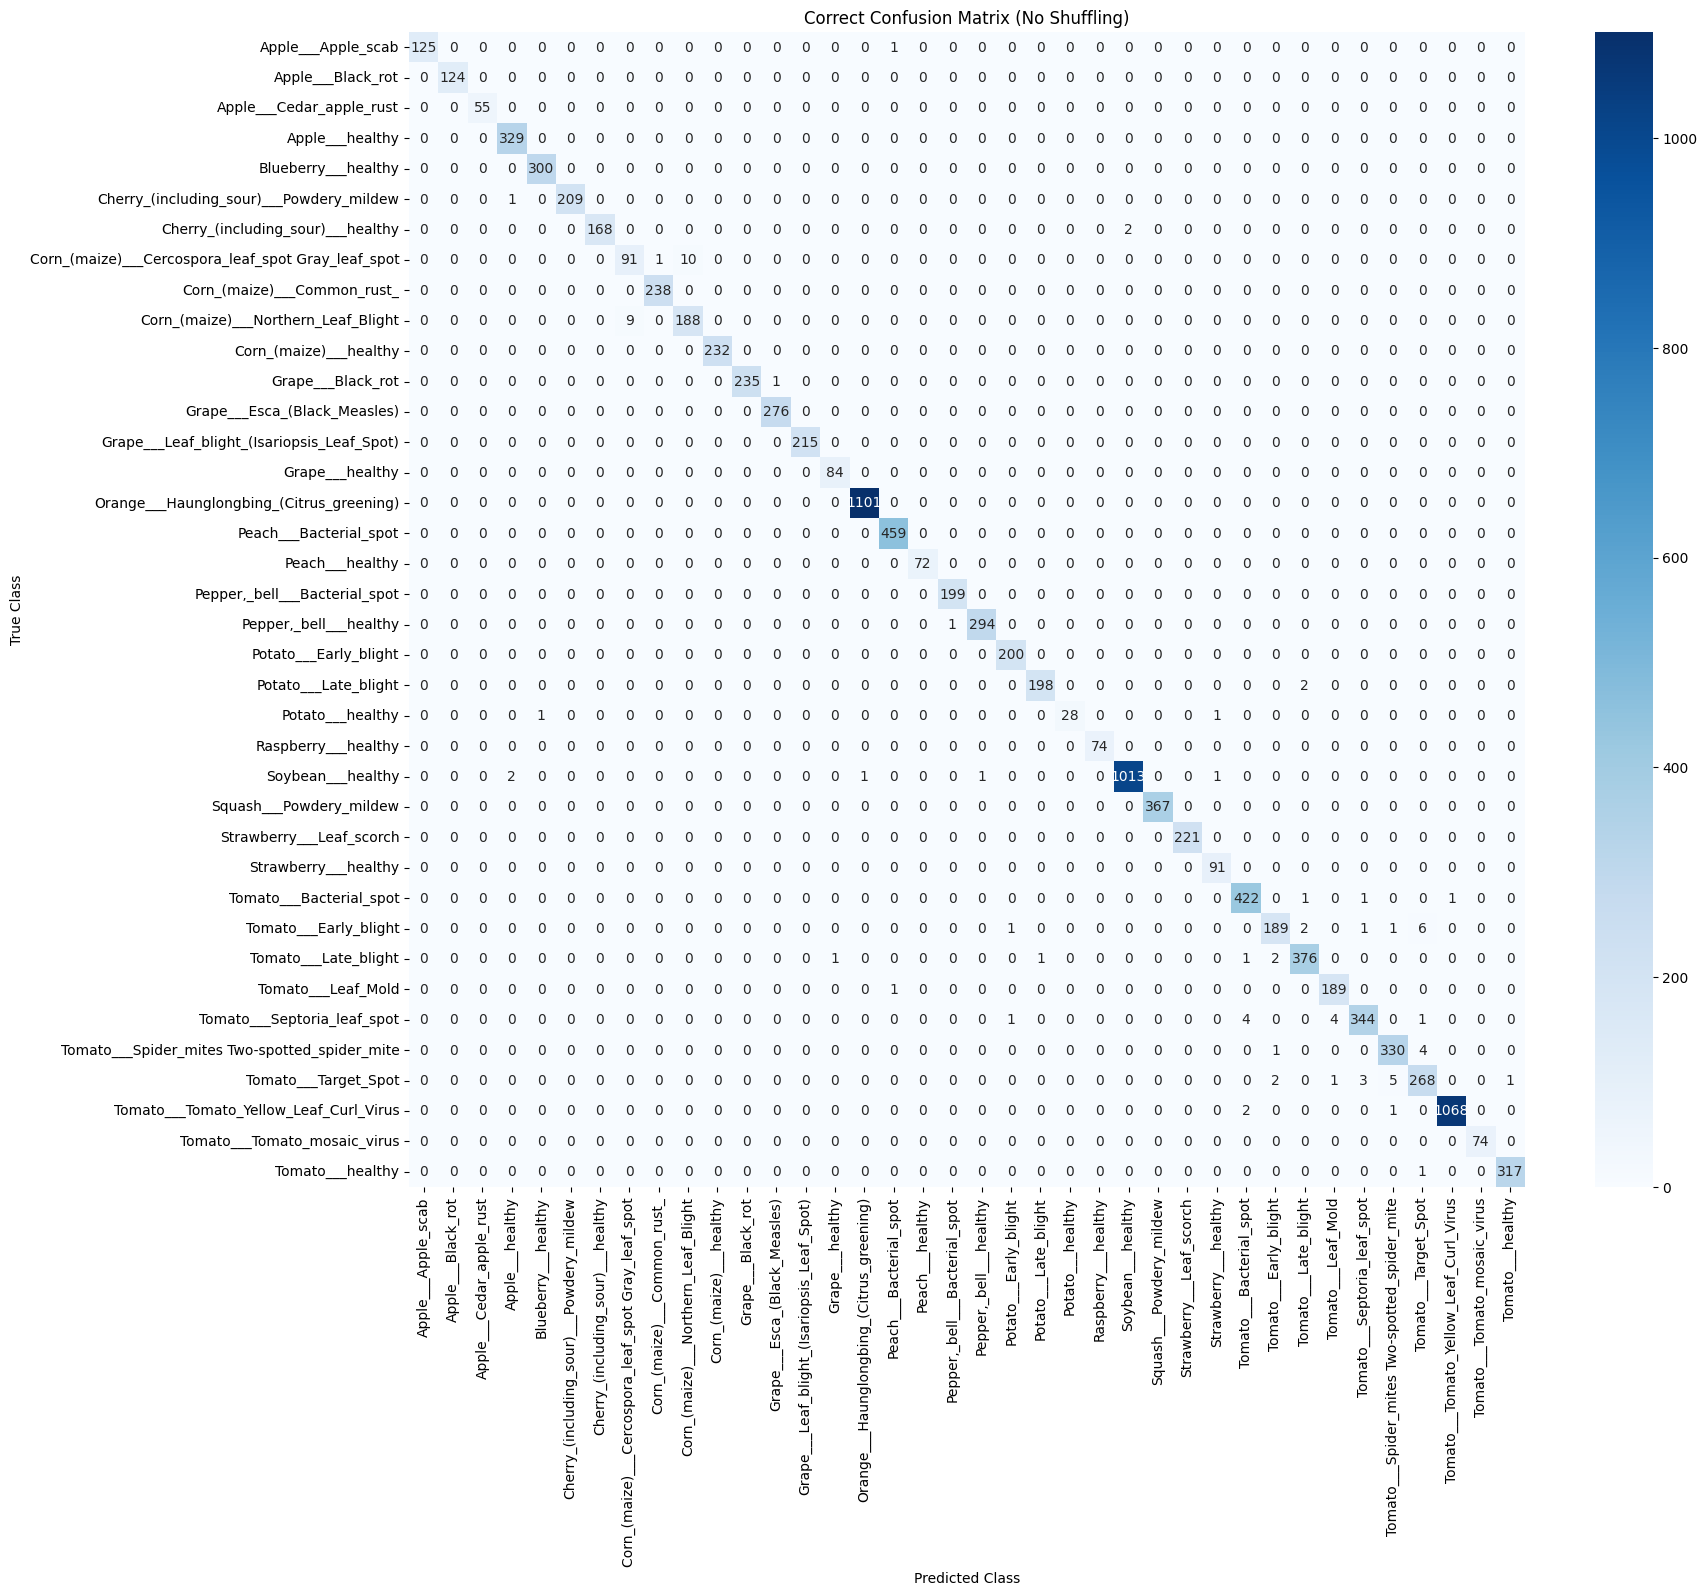

In [40]:
#Plot Confusion Matrix with labels and numbers
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Correct Confusion Matrix (No Shuffling)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [41]:
import numpy as np
from PIL import Image

#Function to Load & Preprocess Image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')  # Ensure 3 channels
    img = img.resize(target_size)               # Resize to 224x224
    img_array = np.array(img) / 255.0           # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension: (1, 224, 224, 3)
    return img_array

#Function to Predict Image Class
def predict_image_class(model, image_path, class_indices):
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions, axis=1)[0]

    # Class name from index
    predicted_class_name = class_indices[predicted_index]

    # Confidence score
    confidence = np.max(predictions) * 100

    return predicted_class_name, confidence

#Convert class_indices from {class_name: index} ➝ {index: class_name}
class_indices = {v: k for k, v in train_generator.class_indices.items()}

#Example to Test Prediction
image_path = "/content/test_leaf.jpg"  # ← Change with your own image path
predicted_class, confidence = predict_image_class(model, image_path, class_indices)
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Class: Tomato___Late_blight
Confidence: 42.53%


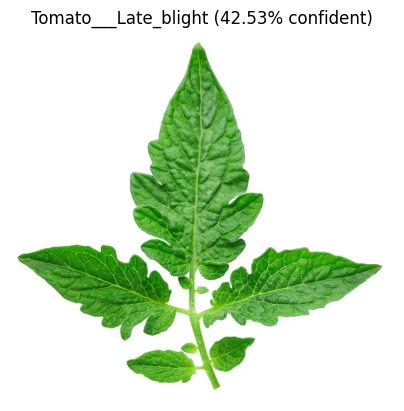

In [42]:
import matplotlib.pyplot as plt

def show_prediction(image_path, predicted_class, confidence):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f}% confident)")
    plt.show()

# To Display:
show_prediction(image_path, predicted_class, confidence)


In [35]:
# Save the trained model
model.save("plant_disease_model.h5")


In [36]:

with open("class_indices.json", "w") as f:
    json.dump(train_generator.class_indices, f)

print("Class labels saved as class_indices.json")

Class labels saved as class_indices.json
